# Portfolio Optimization and Forecasting

## 1. Data

We employ data from the Alpaca using their API

In [236]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import datetime as dt
import time
import matplotlib.pyplot as plt
import hvplot.pandas
import alpaca_trade_api as tradeapi
from scipy.optimize import minimize
import ipywidgets as widgets
import plotly.express as px
%matplotlib inline

In [237]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [238]:
type(alpaca_secret_key)

str

#### Check Available Tickers from Alpaca Markets API

In [239]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]

In [240]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head())

,symbol
0,SQEW
1,KC
2,LSAC
3,OIL
4,CCA


### We asked the user for a list of stocks for the analysis

In [242]:
# inputs from users
answer = 'N'
while answer == 'N':
# number of stocks
    n = int(input("Enter number of tickers : ")) 
  
    # Below line read inputs from user using map() function  
    tickers = list(map(str,input("\nEnter the ticker names separated by a blank space: ").strip().split()))[:n] 
  
    print("\nList of tickers is - ", tickers)
    
    answer = str(input('Is this list is not correct type "N"')) 

Enter number of tickers :  10

Enter the ticker names separated by a blank space:  JPM C MS GS PG JNJ FB AAPL TSLA AA



List of tickers is -  ['JPM', 'C', 'MS', 'GS', 'PG', 'JNJ', 'FB', 'AAPL', 'TSLA', 'AA']


Is this list is not correct type "N" w


In [243]:
# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index df
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head(10)

,AA,AAPL,C,FB,GS,JNJ,JPM,MS,PG,TSLA
,close,close,close,close,close,close,close,close,close,close
time,,,,,,,,,,
2019-01-02 00:00:00-05:00,26.1750,157.5225,53.5099,135.4100,171.5600,127.6800,99.1999,40.305,91.20,309.8699
2019-01-03 00:00:00-05:00,26.2482,142.2900,52.7000,131.8902,169.6300,126.2140,97.3200,39.675,90.71,300.3100
2019-01-04 00:00:00-05:00,28.3850,148.1200,55.1900,137.9400,175.4901,127.8300,100.6600,41.555,92.38,317.5400
2019-01-07 00:00:00-05:00,28.3800,147.9100,55.6550,138.2300,176.0700,127.1400,100.8600,41.770,92.21,334.9860
2019-01-08 00:00:00-05:00,28.2300,150.6300,55.4150,142.5843,175.3200,129.8500,100.4900,41.435,92.50,335.4900
2019-01-09 00:00:00-05:00,29.1150,153.3700,56.4000,144.2500,176.2400,128.8800,100.2800,41.680,91.00,338.5200
2019-01-10 00:00:00-05:00,28.9800,153.5500,56.4700,144.1500,175.9800,129.7650,100.3800,41.650,91.18,344.9100
2019-01-11 00:00:00-05:00,28.4350,152.0534,56.8950,143.7205,176.7900,129.6400,100.0000,41.710,91.66,347.3500


In [244]:
from datetime import datetime
date_format = "%Y-%m-%d"
a = datetime.strptime('2019-01-01', date_format)
b = datetime.strptime('2019-12-31', date_format)

In [245]:
date_format = "%Y-%m-%d"
A = time.strptime('2019-01-01', date_format)
B = time.strptime('2019-12-31', date_format)

In [246]:
# returns of assets
returns_df = df.pct_change()

In [247]:
# Drop Nulls
returns_df.dropna(inplace = True)

In [248]:
returns_df = returns_df.droplevel(axis=1, level=1)

In [249]:
returns_df.hvplot(label = (f"Returns of stocks from dates {b} to {a}"), legend = True)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [250]:
# the function that we'll optimize is "neg_portfolio_sharpR"
def neg_portfolio_sharpR (weights):
    stocks_portfolio_df = returns_df.dot(weights)
    # We need cumulative returns
    stocks_cum_returns_df = ( 1 + stocks_portfolio_df).cumprod()
    # Then we solve for annual_return
    stocks_returns_annual = (stocks_cum_returns_df)**(365/(b -a).days) - 1
    stocks_returns_annual = stocks_returns_annual[-1]
    # compute annual s.d.
    stocks_returns_sd_ann = stocks_portfolio_df.std()*np.sqrt(252)
    # we'll use a minimization routine
    # so we define the Sharpe_ratio as negative
    return (-stocks_returns_annual/stocks_returns_sd_ann)

In [251]:
# checking the function produces sensible results
# with equal weights 
lst = []
for l in range(len(tickers)):
    lst.append(1/len(tickers))
-neg_portfolio_sharpR (lst)

2.1090692763092673

In [252]:
num_assets = len(tickers)
# The constraint is that the sum of weights needs to be equal to 1:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bound = (0.0,1.0) # no negative weights (no short-selling)
bounds = tuple(bound for asset in range(num_assets))
# We use the Sequential Least SQuares Programming (SLSQP) Algorithm
result = minimize(neg_portfolio_sharpR, num_assets*[1./num_assets,],
                        method='SLSQP', bounds=bounds, constraints=constraints)

In [253]:
result

     fun: -3.740704102269756
     jac: array([ 5.64554262e+00, -7.92722434e-01, -4.42222953e-01, -7.92766392e-01,
        2.16129422e-03, -1.81634724e-01, -7.92811930e-01,  9.41644162e-01,
       -7.92976320e-01, -3.38557899e-01])
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([2.41584615e-14, 3.87331456e-01, 0.00000000e+00, 5.98635383e-02,
       0.00000000e+00, 0.00000000e+00, 1.62429627e-01, 3.59889909e-15,
       3.90375379e-01, 0.00000000e+00])

In [254]:
# optimal Sharpe ratio is the negative of the minimum
optimal_Sharpe = -result.fun
optimal_Sharpe

3.740704102269756

In [255]:
# setting up weights in a dataframe
def opt_weights_df(results):
    opt_weights_df = pd.DataFrame(result.x).transpose()
    # renaming columns with tickers names
    opt_weights_df = pd.DataFrame (data = opt_weights_df.values, columns = returns_df.columns)
    return opt_weights_df

In [256]:
opt_weights_df(result)

,AA,AAPL,C,FB,GS,JNJ,JPM,MS,PG,TSLA
0,2.415846e-14,0.387331,0.0,0.059864,0.0,0.0,0.16243,3.598899e-15,0.390375,0.0


In [257]:
opt_weights_transpose = opt_weights_df(result).T

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019C70F034A8>],
      dtype=object)

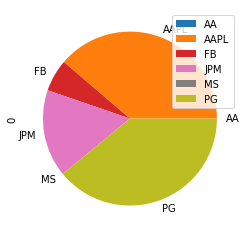

In [258]:
opt_weights_transpose.plot.pie(subplots = True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019C70EC8C50>],
      dtype=object)

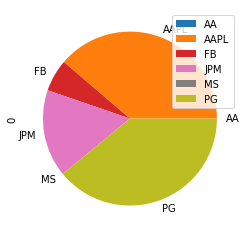

In [259]:
opt_weights_transpose.plot.pie(subplots = True)

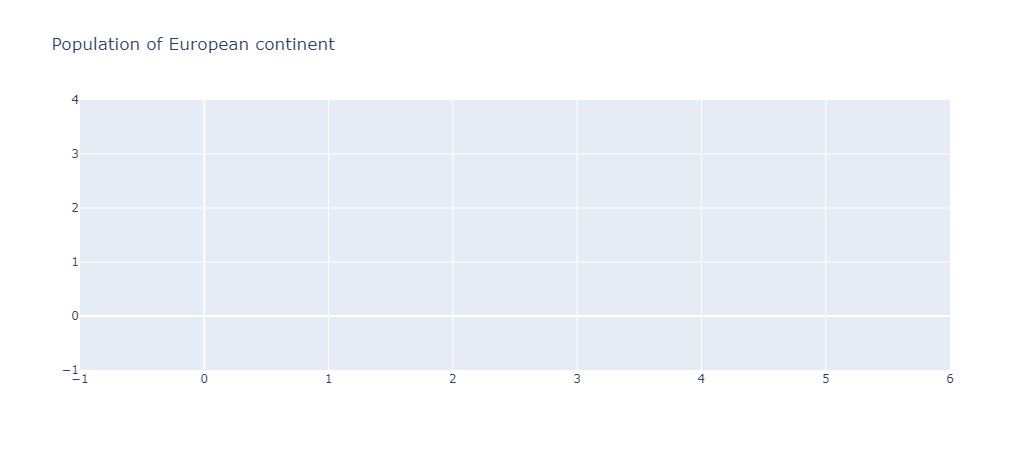

In [260]:
#opt_weights_df(result).px.pie(label = ("Portfolio Sellection: Optimal Weights"), legend = True)
fig = px.pie(opt_weights_transpose,title='Population of European continent')
fig.show()

In [261]:
# return and volatility associated with optimal Sharpe Ratio
# we need two functions
def portfolio_return (weights):
    stocks_portfolio_df = returns_df.dot(weights)
    # We need cumulative returns
    stocks_cum_returns_df = ( 1 + stocks_portfolio_df).cumprod()
    # Then we solve for annual_return
    stocks_returns_annual = (stocks_cum_returns_df)**(365/(b -a).days) - 1
    stocks_returns_annual = stocks_returns_annual[-1]
    return (stocks_returns_annual)

def portfolio_vol (weights):
    stocks_portfolio_df = returns_df.dot(weights)
    # compute annual s.d.
    stocks_returns_sd_ann = stocks_portfolio_df.std()*np.sqrt(252)
    # we'll use a minimization routine
    # so we define the Sharpe_ratio as negative
    return (stocks_returns_sd_ann)

In [262]:
# optimal portfolio return
portfolio_return (result.x)

0.5790601274383846

In [263]:
# optimal portfolio volatility
portfolio_vol(result.x)

0.15479976806693344

In [264]:
# Code to generate the efficient frontier

np.random.seed(42)
# 3000 times the number of stocks seems a sensible value
num_ports = len(tickers)**2 * 1000
all_weights = np.zeros((num_ports, len(tickers)))
# This array contains the returns (lenght num_ports) 
ret_arr = np.zeros(num_ports)
# This array contains the volatilities (lenght num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    w = np.array(np.random.random(len(tickers)))
    # we need to normalize weights so that these add to 1
    w = w/np.sum(w)
    # Save weights
    all_weights[x,:] = w
    
    # For returns we use the same methodology used
    # for previous sections
    stocks_portfolio_df = returns_df.dot(w)
    # We need cumulative returns
    stocks_cum_returns_df = ( 1 + stocks_portfolio_df).cumprod()
    # Then we solve for annual_return
    stocks_returns_annual = (stocks_cum_returns_df)**(365/(b -a).days) - 1
    stocks_returns_annual = stocks_returns_annual[-1]
    # array with final returns
    ret_arr[x] = stocks_returns_annual

    # Expected volatility
    vol_arr[x] = stocks_portfolio_df.std()*np.sqrt(252)
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [265]:
# ef Sharpe ratio
ef_Sharpe = sharpe_arr.max()
ef_Sharpe 

3.3181391746667943

In [266]:
# best weights combination from efficient frontier (sub-optimal)
ef_weights_df = pd.DataFrame(all_weights[sharpe_arr.argmax()]).transpose()
# renaming columns with tickers names
ef_weights_df = pd.DataFrame (data = ef_weights_df.values, columns = returns_df.columns)
ef_weights_df

,AA,AAPL,C,FB,GS,JNJ,JPM,MS,PG,TSLA
0,0.003386,0.230693,0.131504,0.12492,0.029102,0.138781,0.088888,0.019695,0.214678,0.018353


In [267]:
# these two variables kept the return and volatility
# of the maximum Sharpe-ratio
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

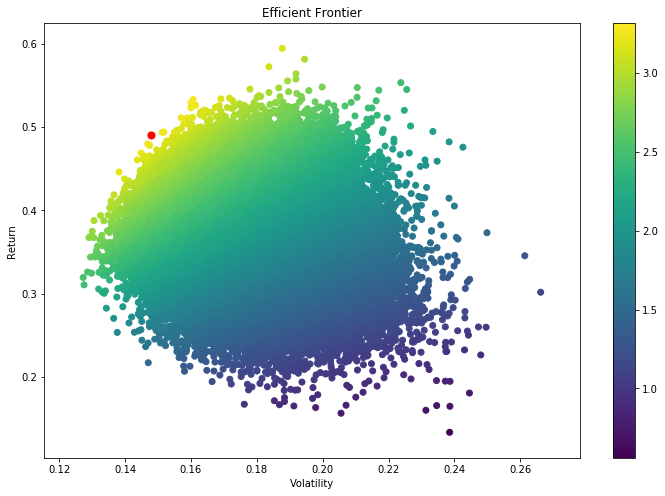

In [268]:
# instructions to plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar()
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
# red dot is the point in the frontier with
# the maximum Sharpe-ratio
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

### Finding the optimal return for a specific level of portfolio volatility

The strategy is to use the same objective function used for the optimal Sharpe ratio: neg_portfolio_sharpR. The variation here is to add add another constraint: a specific level of volatility provided directly by the user. The new constraint is a bit convoluted so we'll set up a specific function for that.

In [269]:
# function computes portfolio-vol for a specific set of weights
def portfolio_volatility(weights):
    stocks_portfolio_df = returns_df.dot(weights)
    stocks_returns_sd_ann = stocks_portfolio_df.std()*np.sqrt(252)
    return stocks_returns_sd_ann

In [270]:
vol_user = 0.20

In [271]:
# new dictionary for the extra-constraint
constraints_fixed_vol = (
   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
   {'type': 'eq', 'fun': lambda x: vol_user - portfolio_volatility(x)}
                        )

In [272]:
# new optimization function
result_fixed_vol = minimize(neg_portfolio_sharpR, num_assets*[1./num_assets,],
                        method='SLSQP', bounds=bounds, constraints=constraints_fixed_vol)
result_fixed_vol

     fun: -3.5897807912298823
     jac: array([ 4.26904479, -0.6357553 , -1.12727243, -1.15133986, -0.59185496,
       -0.36174136, -1.35266629,  0.12028036, -1.46851197, -0.48655519])
 message: 'Optimization terminated successfully.'
    nfev: 84
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([1.48066600e-15, 6.94681368e-01, 0.00000000e+00, 2.83100413e-02,
       9.68436250e-16, 0.00000000e+00, 2.13398705e-16, 1.28013358e-15,
       2.77008591e-01, 5.78552914e-16])

In [273]:
# dataframe with the weights for the user-defined vol level
opt_weights_df(result_fixed_vol)

,AA,AAPL,C,FB,GS,JNJ,JPM,MS,PG,TSLA
0,2.415846e-14,0.387331,0.0,0.059864,0.0,0.0,0.16243,3.598899e-15,0.390375,0.0


In [274]:
result.x

array([2.41584615e-14, 3.87331456e-01, 0.00000000e+00, 5.98635383e-02,
       0.00000000e+00, 0.00000000e+00, 1.62429627e-01, 3.59889909e-15,
       3.90375379e-01, 0.00000000e+00])

In [275]:
# customerl portfolio return
portfolio_return (result_fixed_vol.x)

0.7179561593417563

In [276]:
# sanity check for portfolio volatility
portfolio_vol(result_fixed_vol.x)

0.20000000030524978

### Adding the portfolio frontier line

In [277]:
# initial vol will be 50% of optimal vol
initial_vol = portfolio_vol(result.x) - portfolio_vol(result.x)*0.5
initial_vol

0.07739988403346672

In [278]:
# granularity will be 0.25% vol
delta_vol = 0.0025
vol_points = portfolio_vol(result.x)/delta_vol
vol_points = int(round(vol_points,0))
ef_ret_arr = np.zeros(vol_points)
ef_vol_arr = np.zeros(vol_points)
ef_Sharpe_arr = np.zeros(vol_points)
                      
# we call the minimization routine for each vol_point
ef_lst = []
vol_user = initial_vol

# this loop builds the returns for multiple efficient points 
for n in range(vol_points):
    constraints_fixed_vol = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
    {'type': 'eq', 'fun': lambda x: vol_user - portfolio_volatility(x)})
    result_fixed_vol = minimize(neg_portfolio_sharpR, num_assets*[1./num_assets,],method='SLSQP', 
                                bounds=bounds, constraints=constraints_fixed_vol)
    ef_lst.append(result_fixed_vol.x)
    ef_ret_arr[n]= portfolio_return(result_fixed_vol.x)
    ef_vol_arr[n]= portfolio_vol(result_fixed_vol.x)
    ef_Sharpe_arr[n] = ef_ret_arr[n] / ef_ret_arr[n]
    vol_user = vol_user + delta_vol

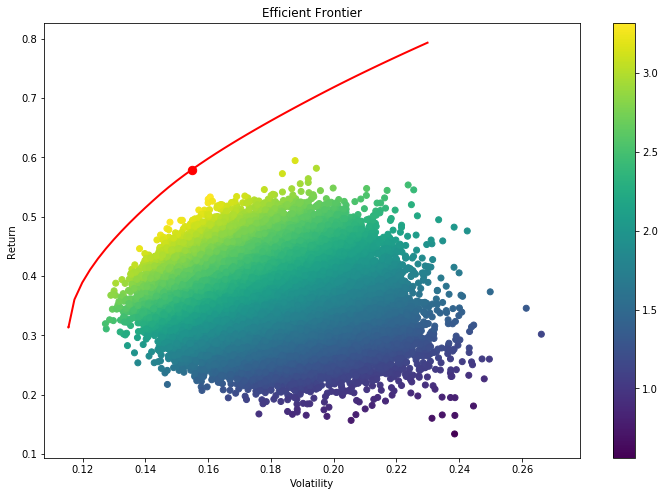

In [279]:
#plotting all together
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar()
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
# red dot is the point in the frontier with
# the maximum Sharpe-ratio
max_sr_ret = portfolio_return (result.x)
max_sr_vol = portfolio_vol(result.x)
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=70) # max Sharpe-ratio dot
plt.plot(ef_vol_arr,ef_ret_arr, 'r-', linewidth=2)
plt.show()

## Using the Sortino Ratio instead of the Sharpe Ratio

The Sortino ratio is like the Sharpe ratio but differs in that it takes account of the downside deviation of the investment as opposed to the standard deviation – i.e., only those returns falling below a specific target, for instance a benchmark. We'll use a bechmark of 0% return. 


In [280]:
# compute s.d. of only negative returns

# we need to compute s.d of each column seperately
# as each column will have different lenghts.
# To do that we convert dataframe into list of lists
lst = []
lst_std = []
for c in range(len(tickers)):
    lst.append(returns_df.iloc[:,c].values.tolist())
    
    # we then filter out postivie returns for each column
    lst[c] = [item for item in lst[c] if item < 0]
    lst_std.append(np.std(lst[c]))

# lst_std contains the modified s.d of return of assets    
sortino_std = pd.DataFrame(lst_std)
sortino_std = sortino_std.T

We define a new objective function for the optimization where the target is the Sortino ratio

In [281]:
def neg_portfolio_sortinoR (weights):
    stocks_portfolio_df = returns_df.dot(weights)
    # We need cumulative returns
    stocks_cum_returns_df = ( 1 + stocks_portfolio_df).cumprod()
    # Then we solve for annual_return
    stocks_returns_annual = (stocks_cum_returns_df)**(365/(b -a).days) - 1
    stocks_returns_annual = stocks_returns_annual[-1]
    # compute annual s.d.
    sortino_std_df = sortino_std.dot(weights)
    stocks_returns_sd_ann = sortino_std_df*np.sqrt(252)
    # we'll use a minimization routine
    # so we define the Sharpe_ratio as negative
    return (-stocks_returns_annual/stocks_returns_sd_ann)

In [282]:
# checking the function produces sensible results
# with equal weights 
lst = []
for l in range(len(tickers)):
    lst.append(1/len(tickers))
-neg_portfolio_sortinoR (lst)

0    1.987775
dtype: float64

In [286]:
# we can now find the optial Sortino ratio
result_sortino = minimize(neg_portfolio_sortinoR, num_assets*[1./num_assets,],
                        method='SLSQP', bounds=bounds, constraints=constraints)
result_sortino

     fun: -4.078916154655811
     jac: array([ 5.75611979, -1.09189039, -0.33279741, -0.25961339,  0.43156511,
        1.44932157, -0.60817492,  1.00161028, -0.67330194,  3.90535969])
 message: 'Optimization terminated successfully.'
    nfev: 24
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1.04083409e-15, 1.00000000e+00, 3.60822483e-16, 7.49400542e-16,
       3.46944695e-16, 2.49800181e-16, 0.00000000e+00, 3.05311332e-16,
       7.49400542e-16, 6.52256027e-16])

In [287]:
opt_weights_sortino_df = pd.DataFrame(result_sortino.x).transpose()
# renaming columns with tickers names
opt_weights_sortino_df = pd.DataFrame (data = opt_weights_df.values, columns = returns_df.columns)
opt_weights_sortino_df

AttributeError: 'function' object has no attribute 'values'

Let's now build the efficient frontier based on the Sotino Ratio

In [290]:
initial_vol = portfolio_vol(result.x) - portfolio_vol(result.x)*0.5

# granularity will be 0.25% vol
delta_vol = 0.0025
vol_points = portfolio_vol(result_sortino.x)/delta_vol
vol_points = int(round(vol_points,0))
ef_ret_arr_sort = np.zeros(vol_points)
ef_vol_arr_sort = np.zeros(vol_points)
ef_Sortino_arr = np.zeros(vol_points)
                      
# we call the minimization routine for each vol_point
ef_lst = []
vol_user = initial_vol

# this loop builds the returns for multiple efficient points 
for n in range(vol_points):
    constraints_fixed_vol = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
    {'type': 'eq', 'fun': lambda x: vol_user - portfolio_volatility(x)})
    result_fixed_vol_sort= minimize(neg_portfolio_sortinoR, num_assets*[1./num_assets,],method='SLSQP', 
                                bounds=bounds, constraints=constraints_fixed_vol)
    ef_lst.append(result_fixed_vol.x)
    ef_ret_arr_sort[n]= portfolio_return(result_fixed_vol_sort.x)
    ef_vol_arr_sort[n]= portfolio_vol(result_fixed_vol_sort.x)
    ef_Sortino_arr[n] = ef_ret_arr_sort[n] / ef_ret_arr_sort[n]
    vol_user = vol_user + delta_vol

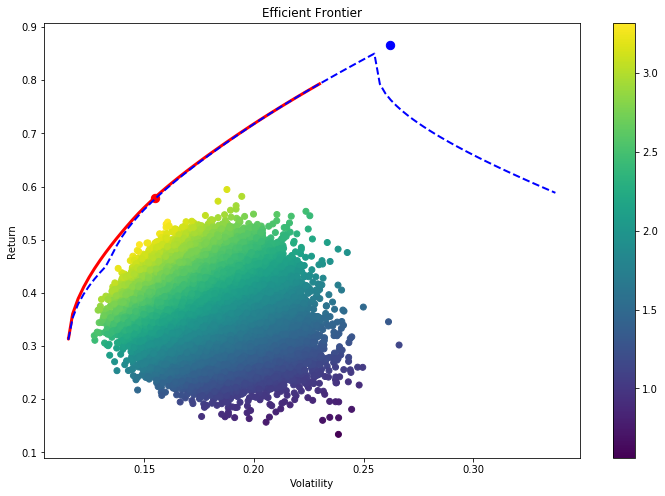

In [291]:
#plotting all together
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar()
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
# red dot is the point in the frontier with
# the maximum Sharpe-ratio
max_sr_ret = portfolio_return (result.x)
max_sr_vol = portfolio_vol(result.x)
max_sr_ret_sort = portfolio_return (result_sortino.x)
max_sr_vol_sort = portfolio_vol(result_sortino.x)
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=70) # max Sharpe-ratio dot
plt.scatter(max_sr_vol_sort, max_sr_ret_sort,c='blue', s=70)
plt.plot(ef_vol_arr,ef_ret_arr, 'r-', linewidth= 3)
plt.plot(ef_vol_arr_sort,ef_ret_arr_sort, 'b--', linewidth=2)
plt.show()

___
## Forecasting portfolio returns

In [210]:
# Setup the Monte Carlo Parameters
number_simulations = 50
number_records = 250* 1
monte_carlo = pd.DataFrame()

In [211]:
# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [212]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):

    # let's set-up data structure
    simulated_PRICES_df = pd.DataFrame()
    # start of simulation is last historical price
    last_prices_df = df[-1:]
    
    # Very first simulation is based on history
    simulated_price_df = last_prices_df * (1 + np.random.normal(returns_df.mean(), returns_df.std()))

    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_price_df = simulated_price_df * (1 + np.random.normal(returns_df.mean(), returns_df.std()))

                
        # Concatenate new simulated price to existing simulated dataframe
        simulated_PRICES_df = pd.concat([simulated_PRICES_df,simulated_price_df], axis = 'index')
        

    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_PRICES_df.pct_change()


    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(result.x)
    
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

In [213]:
portfolio_cumulative_returns.reset_index(inplace = True)

In [214]:
del portfolio_cumulative_returns['time']

In [215]:
portfolio_cumulative_returns.mean().mean()

1.2556610312435441

In [216]:
portfolio_cumulative_returns.hvplot(label = (f"Monte Carlo Simulation over {number_records} days for {number_simulations} simulations"),
                                    legend = False).opts(fontscale=1.3, width=900, height=500)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [217]:
# Display the 90% confidence interval for the ending returns
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
plt.figure();
ending_cumulative_returns.hvplot.hist(bins = 10)
#plt.axvline(confidence_interval.iloc[0], color='r')
#plt.axvline(confidence_interval.iloc[1], color='r')

:Histogram   [249]   (249_count)

<Figure size 432x288 with 0 Axes>